In [2]:
#!pip install ultralytics
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToTensor
from pathlib import Path
import seaborn as sns
import seaborn as sns
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from ultralytics import YOLO
from timm.data import Mixup
from torchvision.transforms import RandomErasing


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:

class_indexes_path = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/class_indexes.csv'
class_indexes = pd.read_csv(class_indexes_path)
class_to_idx = dict(zip(class_indexes['category_cub'], class_indexes['idx']))
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_dir = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/train_images'
val_dir = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/val_images'
test_dir = '//kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/test_images'
yolo_model = YOLO('yolov5su.pt')

100%|██████████| 17.7M/17.7M [00:00<00:00, 29.9MB/s]


In [4]:
def detect_bird_region(image_path):
    results = yolo_model(image_path,verbose=False)
    bird_boxes = results[0].boxes[results[0].boxes.cls == 14]  # 14 is the class index for birds 
    if len(bird_boxes) > 0:
        return bird_boxes[0].xyxy[0].cpu().numpy()  # Return coordinates of the first detected bird
    return None


def preprocess_image(image_path):
    bird_box = detect_bird_region(image_path)
    if bird_box is not None:
        image = Image.open(image_path).convert('RGB')
        bird_image = image.crop(bird_box)
        return bird_image
    return Image.open(image_path).convert('RGB')


In [5]:
class BirdDataset(Dataset):
    def __init__(self, path, transforms=None, has_labels=True):
        super().__init__()
        self.path = path
        self.has_labels = has_labels
        self.transforms = transforms
        
        self.image_path = []  
        self.labels = []      
        
        if has_labels:
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(f.name for f in Path(path).iterdir() if f.is_dir()))}
            
            for class_name in self.class_to_idx.keys():
                class_dir = Path(path) / class_name
                for img_path in class_dir.glob("*.jpg"): 
                    self.image_path.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        else:
            # For test dataset (no labels), 
            self.image_path = list(Path(path).rglob("*.jpg"))

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_path[idx]
        # apply yolo
        image = preprocess_image(image_path)

        # Apply transformations to image
        if self.transforms:
            image = self.transforms(image)

        if self.has_labels:
            label = self.labels[idx]
            return image, label

        # For test set, return only image and filename
        return image, image_path.name

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomErasing(p=0.5) 
])

mixup = Mixup(mixup_alpha=0.2, cutmix_alpha=0.2, prob=0.5, label_smoothing=0.1)

In [7]:
def show_images(images, labels, classes, title, n_cols=8):
    n_rows = len(images) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
    axes = axes.flatten()

    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        ax.set_title(classes[label] if isinstance(label, int) else classes[label.item()])

    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    


In [8]:
def plot_class_distribution(train_dir):
    class_labels = []
    
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        
        if os.path.isdir(class_path):
            num_images = len([img for img in os.listdir(class_path) if img.endswith('.jpg')])
            class_labels.extend([class_name] * num_images)
    
    class_counts = Counter(class_labels)
    
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(15, 5))
    sns.barplot(x=class_names, y=counts)
    plt.xticks(rotation=90)
    plt.title('Class Distribution in Train Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

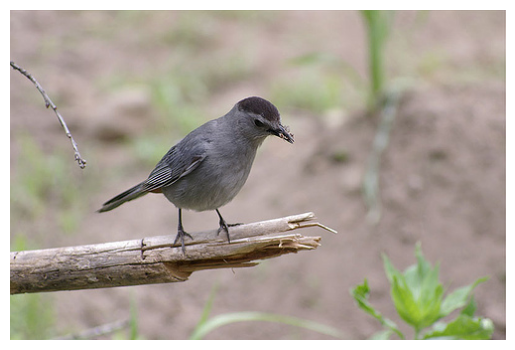

In [9]:
# Orginal Image
image_path = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/train_images/019.Gray_Catbird/Gray_Catbird_0043_21008.jpg'

image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  
plt.show()

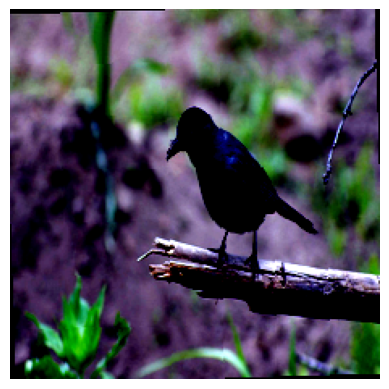

In [10]:
# Trasnformed Image

transformed_image = train_transform(image)

transformed_image = transformed_image.permute(1, 2, 0).numpy()

plt.imshow(transformed_image)
plt.axis('off')  
plt.show()

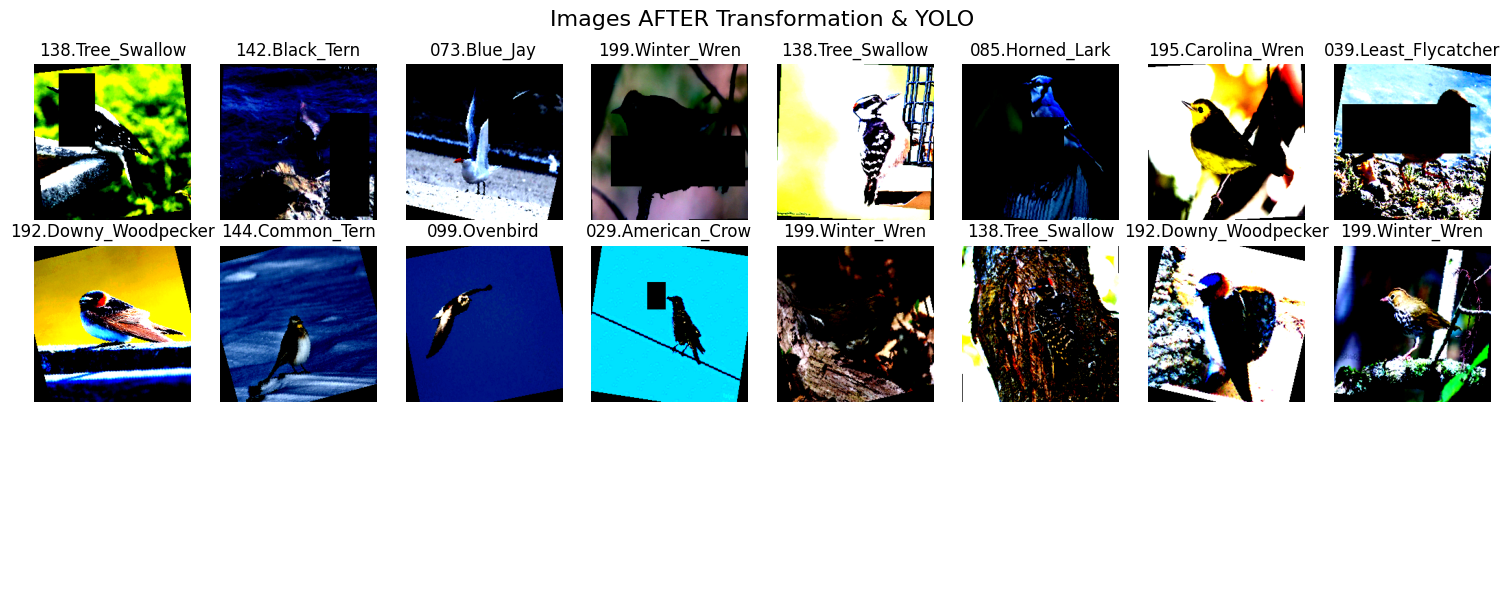

In [11]:
# Apply transformations to the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

train_loader= DataLoader(train_dataset, batch_size=16, shuffle=True)

images, labels= next(iter(train_loader))

show_images(images, labels, idx_to_class, title="Images AFTER Transformation & YOLO")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


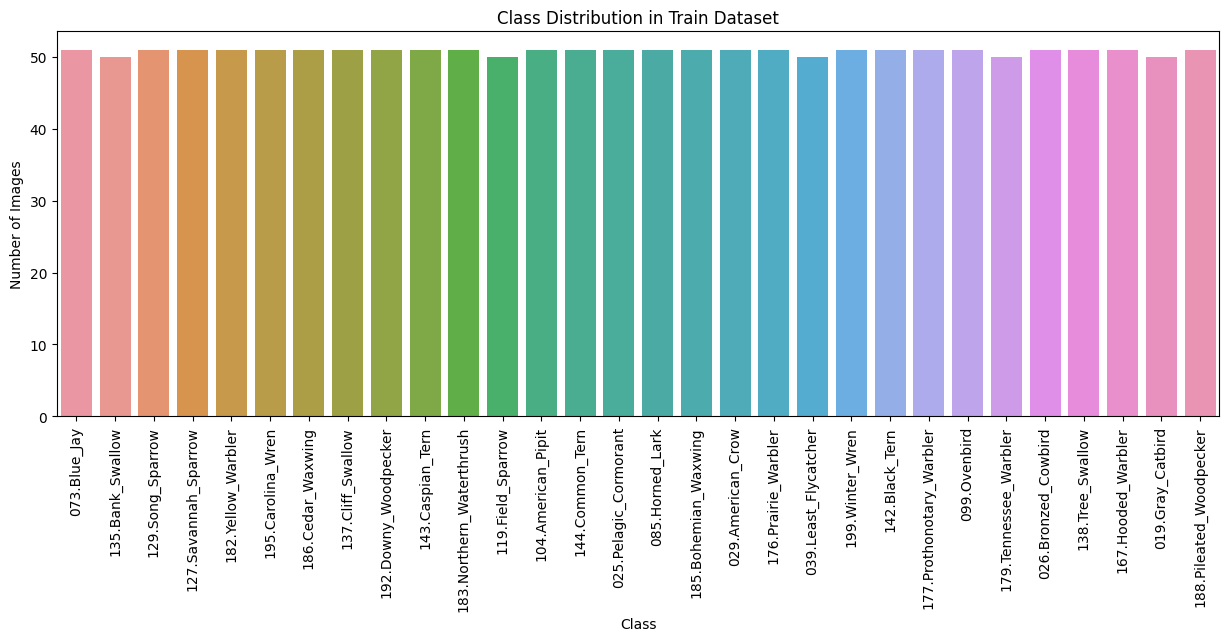

In [12]:
#  class distribution
plot_class_distribution(train_dir)